In [1]:
using DataFrames
using Chemfiles
using Plots, LaTeXStrings, FileIO
home = "/home/german/labo/18/lbp/run"
rtdos = "/home/german/labo/18/lbp/rtdos_log"

"/home/german/labo/18/lbp/rtdos_log"

In [2]:
# Agarra una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3x3N. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas de carbonos alfa
function format_pca_aa(in_mtx::Array{Float64, 2})
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]

    aa = Int64
    try
        aa = convert(Int64, v_length / 3)
    catch
        error("Vector length: ", v_length, " is not divisible by 3.")
    end

    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    for j = 1:v_nbr
        list_out_mtx[j] = reshape(in_mtx[:, j], 3, aa)
    end

    return list_out_mtx
end


# Agarra la topología una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3xNatomos. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas del pdb q dió lugar a la topología.

# También devuelve un array con el nro de atomos q tiene c/ aa
function format_pca_atom(in_top::Topology, in_mtx::Array{Float64, 2}, mask::Array{Float64, 1} = 0)
    # Preparo variables
    aa = Int64
    aa_3 = Int64
    if mask == 0 
        aa = convert(Int64, count_residues(in_top))
    else
        aa = length(mask)
    end
    aa_3 = aa * 3
    
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]
    if v_length != aa_3
        error("Input vector with wrong dimensions: ", v_length, "  ", (aa_3, 1))
    end

    # Determino orden de residuos (hay q actualizar el Julia Chemfiles)
    tmp = Array{Int64}(aa)
    ids = Array{Int64}(aa)
    [ ids[i+1] = convert(Int64, id((Residue(in_top, i)))) for i = 0:aa-1 ]
    idx = sortperm(ids)
    # Determino el nro de atomos de c/ aminoácido. Resto 1 pq Chemfiles tiene 0-indexing
    [ tmp[i] = size(Residue(in_top, mask[i] - 1)) for i = 1:aa ]
    natom_aa = tmp[idx]
    natoms = sum(natom_aa)

    # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    
    for j in 1:v_nbr
        vector = reshape(in_mtx[:, j], 3, aa)
        list_out_mtx[j] = Array{Float64}(3, natoms)
        cursor = 0
        for i = 1:aa
            rango = Array{Int64}(natom_aa[i])
            if i == 1
                list_out_mtx[j][:, 1:natom_aa[i]] = repmat(vector[:, i], 1, natom_aa[i])
                cursor = natom_aa[i]
                continue
            end
            rango = collect(cursor+1:cursor + natom_aa[i])
            list_out_mtx[j][:, rango] = repmat(vector[:, i], 1, natom_aa[i])
            cursor += natom_aa[i]
        end
    end

    return list_out_mtx, natom_aa
end

format_pca_atom (generic function with 2 methods)

In [3]:
function get_κ(in_vec::Array{Float64, 1})
    not_null = copy(in_vec)
    not_null[not_null .== 0] = 0.000001
    const κ = (exp.(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log.(x.^2), not_null, 1), 1))
        / length(not_null))[1]
    return κ
end

function get_pnum(in_vec::Array{Float64, 1})
    nor_vec = in_vec ./ norm(in_vec) 
    return convert(Int64, round(sum(nor_vec .^ 4) .^ -1))
end

function tognm(vtor_anm)
    vtor_gnm = Array{Float64}
    try
        vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    catch e
        warn("Input vector's length is not a 3 multiplier")
        error(e)
    end
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function WeightedHist(in_vec, in_bins, in_weight, density = false, include_bounds = true)
    # Safety check    
    if length(in_vec) != length(in_weight)
        error("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    if include_bounds
        for i=1:length(in_bins)-1
            if i == 1
                # Include those that fall before the beggining of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
                out_counts[i] = sum(in_weight[temp_bool])
            elseif i == length(in_bins)-1
                # Include those that fall after the end of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
                out_counts[i] = sum(in_weight[temp_bool])
            else
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
                out_counts[i] = sum(in_weight[temp_bool])
            end
        end
    else
        for i=1:length(in_bins)-1
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

function MatHisInd2D(in_vec_x::AbstractArray, in_vec_y::AbstractArray,
    in_bins_x::AbstractArray, in_bins_y::AbstractArray,
    include_bounds = true)

    const cnt = length(in_vec_x)
    if  length(in_vec_y) != cnt
        error("Input vectors length don't match. X: ", in_vec_x, " Y: ", in_vec_y)
    end
         
    const n_x = length(in_bins_x)
    const n_y = length(in_bins_y)
    
    his_ind = [Int[] for i=1:n_x, j=1:n_y]
    his = zeros(Int64, n_x, n_y)
    if include_bounds
        for i in 1:cnt
            x = searchsortedfirst(in_bins_x, in_vec_x[i])
            y = searchsortedfirst(in_bins_y, in_vec_y[i])
            if x > n_x
                x = n_x
            end
            if y > n_y
                y = n_y
            end
            
            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    else
        for i in 1:cnt
            const x = searchsortedfirst(in_bins_x, in_vec_x[i])
            const y = searchsortedfirst(in_bins_y, in_vec_y[i])
        
            if x > n_x || y > n_y
                continue
            end
            if (x == 1 && isless(x, in_vec_x[x])) || (y == 1 && isless(y, in_vec_y[y]))
                continue
            end

            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    end
    
    return his_ind, his
end

function read_ptraj_modes(filename, nmodes::Int64=0, norma::Bool=true)
    modes_text = readdlm(filename, skipstart=0, skipblanks=true, comments=true,
        comment_char='\*')

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    modes_elements = modes_text[2, 1]

    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)

    eval = Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1 = Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end

    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end

    return mode, eval
end

function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 298
    const RT =  k * avgdro * T * 1E-3 * 0.239006 # Kcal/mol
    const cte = 11792.08316093831
    
    return d^2 * 0.5 * RT * sum(evals.^2 .* gdte.^2) / cte # Kcal/mol
end

energia_gdte (generic function with 2 methods)

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [4]:
pdb = "1ure"
# Leo modos
modes_1ure, evals_1ure = read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_1ure))
aa = convert(Int64,aa3 / 3)

# Leo volúmenes originales
vol_avg_1ure = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_1ure = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_1ure = eval(:(ndd_out_1ure .- vol_avg_1ure))
vgv_1ure = vgv_1ure ./ norm(vgv_1ure);

### Obtiene los aa's del hueco

In [5]:
# VGV cartesiano
xyz_vgv_1ure = tognm(modes_1ure * vgv_1ure)

# Pnumber aminoácidos según VGV (aminoácidos de la pared)
cut_1ure = get_pnum(xyz_vgv_1ure)

# Índices de pnumber aminoácidos
idx_cut_1ure = sort(sortperm(abs.(xyz_vgv_1ure), rev = true)[1:cut_1ure])

# Índices de pnumber aminoácidos en 3aa coordenadas
idx_cut_1ure_3 = Array{Int64}(length(idx_cut_1ure) * 3)
for i = 1:length(idx_cut_1ure)
    idx_cut_1ure_3[3*i-2] = idx_cut_1ure[i] * 3 - 2
    idx_cut_1ure_3[3*i-1] = idx_cut_1ure[i] * 3 - 1
    idx_cut_1ure_3[3*i] = idx_cut_1ure[i] * 3
end

### Obtiene los pnum modos y pnum eigenvals. Cut y enteros

In [6]:
# Pnumber de VGV
vgv_pnu_1ure = get_pnum(vgv_1ure)

# Pnumber indices
idx_vgv_pnu_1ure = sortperm(abs.(vgv_1ure), rev=true)[1:vgv_pnu_1ure]

# Pnumber modes
modes_pnu_1ure = modes_1ure[:, idx_vgv_pnu_1ure]

# Pnumber eigenvalues
evals_pnu_1ure = evals_1ure[idx_vgv_pnu_1ure];

# Todos los modos recortados según pnumber aminoácidos y normalizo
modes_cut_1ure = modes_1ure[idx_cut_1ure_3, :]
modes_cut_1ure = mapslices(x -> x ./ norm(x), modes_cut_1ure, 1)

# Pnum modos recortados según pnumber aminoácidos y normalizo
modes_pnu_cut_1ure = modes_pnu_1ure[idx_cut_1ure_3, :]
modes_pnu_cut_1ure = mapslices(x -> x ./ norm(x), modes_pnu_cut_1ure, 1);

### κ

In [7]:
# Colectividad de modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_1ure, 1), 1)))
κ_modes_1ure = reshape(tmp, length(tmp))

# Colectividad de pnum modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_pnu_1ure, 1), 1)))
κ_modes_pnu_1ure  = reshape(tmp, length(tmp))

# Colectividad de modos recortados
tmp = mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_cut_1ure, 1), 1)
κ_modes_cut_1ure  = reshape(tmp, length(tmp))

# Colectividad de pnum modos recortados
tmp = mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_pnu_cut_1ure, 1), 1)
κ_modes_pnu_cut_1ure = reshape(tmp, length(tmp));

### Pnumber

In [8]:
# Pnumber de modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_1ure, 1), 1)
col_modes_1ure = reshape(tmp, length(tmp)) ./ aa

# Pnumber de pnum modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_pnu_1ure, 1), 1)
col_modes_pnu_1ure = reshape(tmp, length(tmp)) ./ aa

# Pnumber de modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_cut_1ure, 1), 1)
col_modes_cut_1ure = reshape(tmp, length(tmp))  ./ cut_1ure

# Pnumber de pnum modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_pnu_cut_1ure, 1), 1)
col_modes_pnu_cut_1ure = reshape(tmp, length(tmp))  ./ cut_1ure;

# Frecuencia

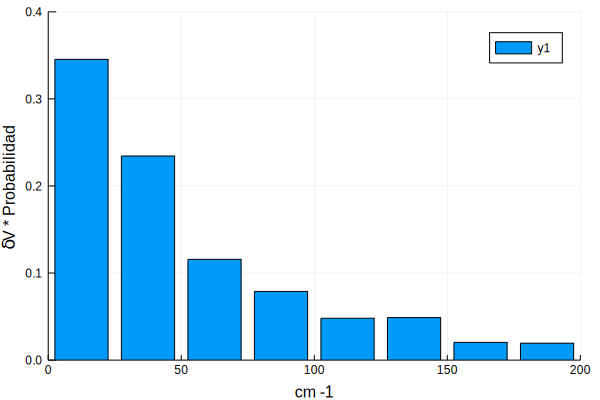

In [9]:
# Los bins van de 0 a la fqcia más alta + 10%
top_evals = maximum(evals_1ure)
bins_evals = collect(0:25:400)

# Histograma ponderado
Whis_evals_1ure, Wbins_evals_1ure = WeightedHist(evals_1ure, bins_evals, abs.(vgv_1ure), true);

bar(Wbins_evals_1ure, Whis_evals_1ure,
    xlims = (0, 200), ylims = (0, .4),
    yaxis = "\\deltaV * Probabilidad", xaxis = "cm -1")

# Colectividad

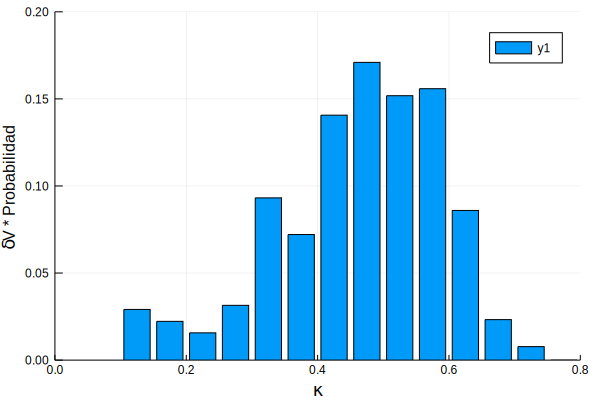

In [10]:
# Los bins van de 0 a la fqcia más alta + 10%
top_κ = maximum(κ_modes_1ure)
bins_κ = collect(0.1:.05:.8)

# Histograma ponderado
Whis_κ_1ure, Wbins_κ_1ure = WeightedHist(κ_modes_1ure, bins_κ, abs.(vgv_1ure), true);

bar(Wbins_κ_1ure, Whis_κ_1ure,
    xlims = (0, .8), ylims = (0, .2),
    yaxis = "\\deltaV * Probabilidad", xaxis = "\\kappa")

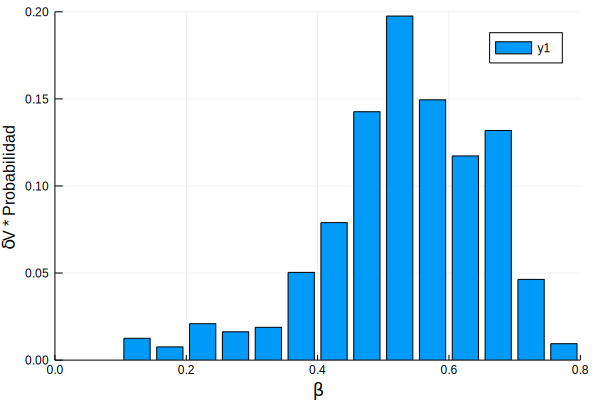

In [11]:
# Histograma ponderado
Whis_κ_cut_1ure, Wbins_κ_cut_1ure = WeightedHist(κ_modes_cut_1ure, bins_κ, abs.(vgv_1ure), true);

bar(Wbins_κ_cut_1ure, Whis_κ_cut_1ure,
    xlims = (0, .8), ylims = (0, .2),
    yaxis = "\\deltaV * Probabilidad", xaxis = "\\beta")

## Colectividad en pnumber

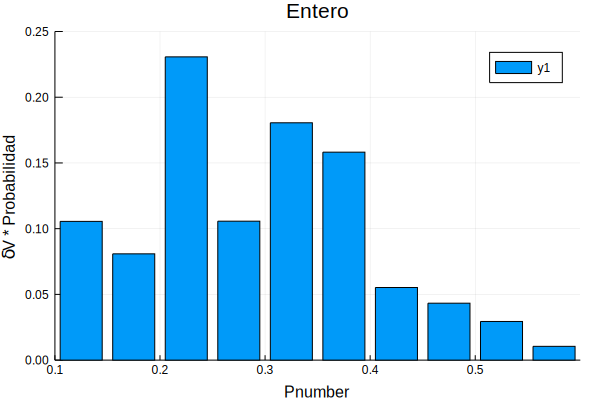

In [12]:
# Los bins van de 0 a la fqcia más alta + 10%
top_col = maximum(col_modes_1ure)
bins_col = collect(0.1:.05:.6)

# Histograma ponderado
Whis_col_1ure, Wbins_col_1ure = WeightedHist(col_modes_1ure, bins_col, abs.(vgv_1ure), true);

bar(Wbins_col_1ure, Whis_col_1ure,
    xlims = (0.1, .6), ylims = (0, .25),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "Entero")

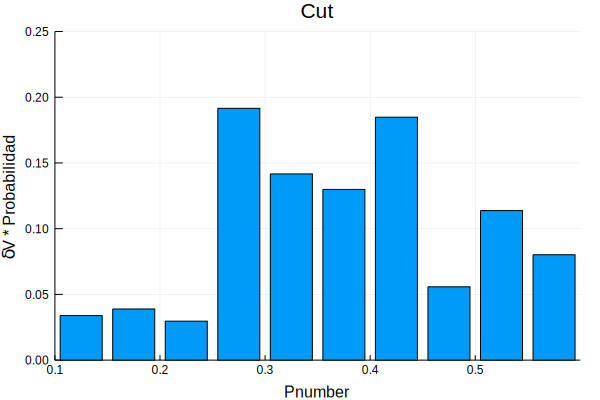

In [13]:
# Los bins van de 0 a la fqcia más alta + 10%
top_col = maximum(col_modes_1ure)
bins_col = collect(0.1:.05:.6)

# Histograma ponderado
Whis_col_cut_1ure, Wbins_col_cut_1ure = WeightedHist(col_modes_cut_1ure, bins_col,
    abs.(vgv_1ure), true);

bar(Wbins_col_cut_1ure, Whis_col_cut_1ure,
    xlims = (0.1, .6), ylims = (0, .25),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "Cut",
    legend = false)

## AAs de la pared

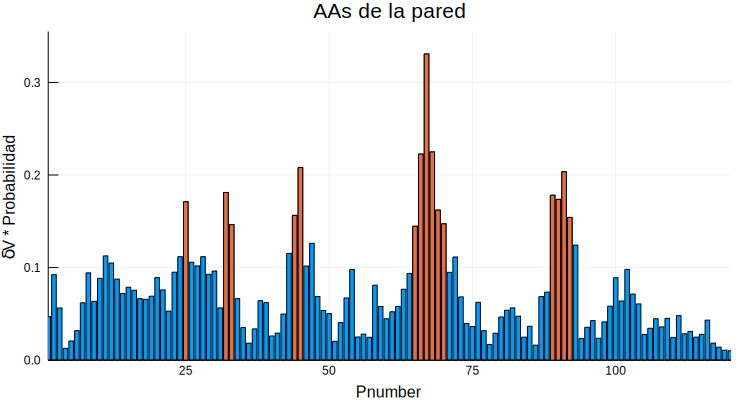

In [14]:
tmp = abs.(xyz_vgv_1ure)
tmp_ = copy(tmp)
tmp_[tmp_ .< .13] .= 0.;

bar(tmp,
    xlims = (1, 120), ylims = (0, .355),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "AAs de la pared",
    legend = false, size = (750, 400))
bar!(tmp_)

## Volumen de la trayectoria

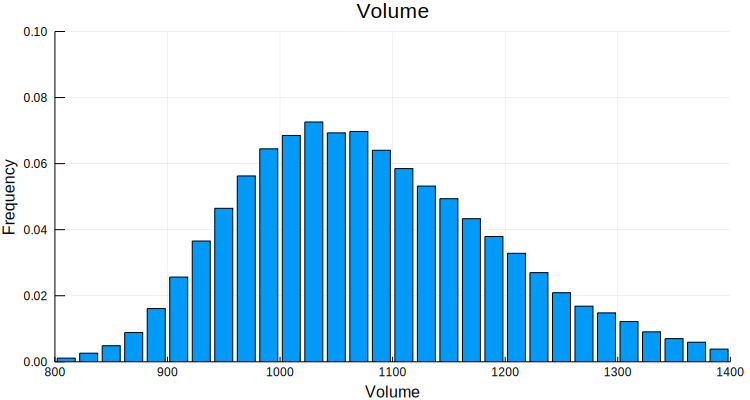

In [15]:
trj_vol = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

bin_vol = collect(800:20:1400)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Whis_vol_1ure, Wbins_vol_1ure = WeightedHist(trj_vol, bin_vol, wgh_vol, true, false);

bar(Wbins_vol_1ure, Whis_vol_1ure,
    xlims = (800, 1400), ylims = (0, .1),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    legend = false, size = (750, 400))

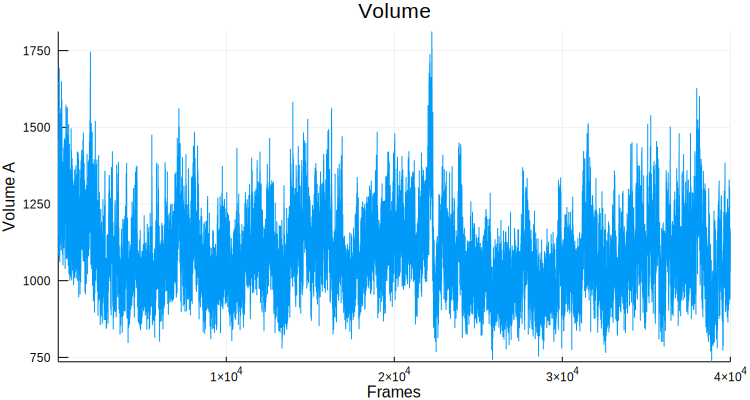

In [16]:
plot(trj_vol,
    yaxis = "Volume A", xaxis = "Frames", title = "Volume",
    legend = false, size = (750, 400))

In [17]:
[ mean(trj_vol) ; std(trj_vol) ]

2-element Array{Float64,1}:
 1083.31 
  120.022

# Energía

In [18]:
points = 21
maxi = floor(points / 2)
mini = -maxi
RT = 0.693

E_1ure = Array{Float64,1}(points)
i = 0
for d = mini:maxi
    i+=1
    E_1ure[i] = energia_gdte(evals_1ure, vgv_1ure, d * 5E-1)
end

In [1]:
plot(collect(-5:.5:5), E_1ure,
    yaxis = "U", xaxis = "Displacement", title = "Energia",
    xticks = -5:1:5,
    ylims = (0, 1.),
    legend = false, size = (750, 400))
hline!([RT])

LoadError: [91mUndefVarError: plot not defined[39m

# PCA projección

#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

#### Leo los vectores diferencia y los normalizo
#### Obtengo las proyecciónes de vectores diferencia sobre los 1eros PCA

In [22]:
diff_1ure = readdlm(joinpath(rtdos, string("diff_", pdb)))
nframes = size(diff_1ure)[2]
norm_diff_1ure = mapslices(x -> x ./ norm(x), diff_1ure, 1);

prj_1_1ure = Array{Float64, 1}(nframes)
prj_2_1ure = Array{Float64, 1}(nframes)

for i = 1:nframes
    prj_1_1ure[i] = dot(norm_diff_1ure[:, i], modes_1ure[:, 1])
    prj_2_1ure[i] = dot(norm_diff_1ure[:, i], modes_1ure[:, 2])
end

# Smooth
smooth_prj_1_1ure = [ mean(prj_1_1ure[i:i+10]) for i = 1:10:length(prj_1_1ure)-10 ]
smooth_prj_2_1ure = [ mean(prj_2_1ure[i:i+10]) for i = 1:10:length(prj_2_1ure)-10 ];

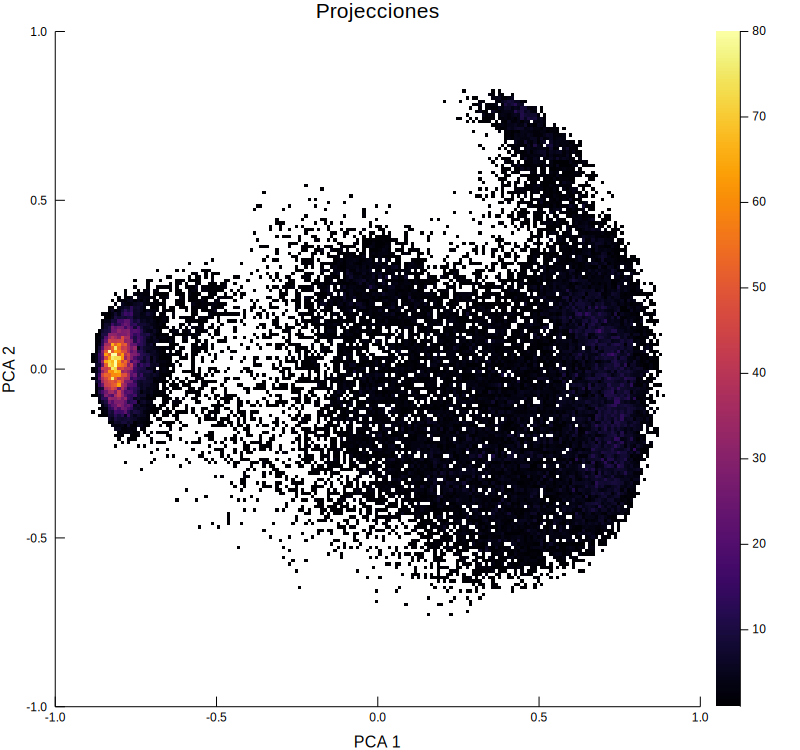

In [62]:
plt_2his = histogram2d(smooth_prj_1_1ure, smooth_prj_2_1ure, 
    xlims = (-1., 1.), ylims = (-1., 1.),
    yaxis = "PCA 2", xaxis = "PCA 1", title = "Projecciones",
    clims = (1, 80), colorbar_title = "Frame count",
    grid = false, linealpha = 0,
    nbins = 200, size = (800, 750))

In [71]:
# Projecciones de PCA
df_prj = DataFrame(PCA1 = smooth_prj_1_1ure, PCA2 = smooth_prj_2_1ure);
save(joinpath(rtdos, string("2his_prj_", pdb, ".csv")), df_prj, quotechar = nothing)
# Volumen
df_vol = DataFrame(Volumen = trj_vol);
save(joinpath(rtdos, string("his_vol_", pdb, ".csv")), df_vol, quotechar = nothing)

png(plt_his_vol, joinpath(rtdos, "papel", string("plt_his_vol_", pdb)))
png(plt_2his, joinpath(rtdos, "papel", string("plt_2his_", pdb, ".png")))
